In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import osmnx as ox
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from itertools import cycle
import matplotlib.cm as cm
from scipy.spatial import Voronoi
from shapely import geometry, ops
import random
import geopandas as gpd
from shapely.geometry import Polygon

def get_Graph(city):
    nodes, edges = pd.read_csv(f"./Results/csv/{city}_nodes.csv", index_col =[0]), pd.read_csv(f"./Results/csv/{city}_edges.csv", index_col = [0,1,2], encoding = 'latin-1')
    edges["highway"] = edges.highway.map(lambda x: x[0] if isinstance(x, list) else x)
    others = ["crossing", "living_street", "unclassified", "disused", "busway", "escape", "road"]
    edges["highway"] = edges.highway.map(lambda x: "other" if x  in others else x)
    s = gpd.GeoSeries.from_wkt(nodes.geometry)
    nodes = gpd.GeoDataFrame(data = nodes, geometry = s)
    nodes = nodes.set_crs('epsg:4326', allow_override=True)
    s = gpd.GeoSeries.from_wkt(edges.geometry)
    edges = gpd.GeoDataFrame(data = edges, geometry = s)
    edges = edges.set_crs('epsg:4326', allow_override=True)

    G = ox.graph_from_gdfs(nodes, edges)
    H = nx.MultiDiGraph()
    H.add_nodes_from(sorted(G.nodes(data=True)))
    H.add_edges_from(G.edges(data=True))
    H.graph["crs"] = G.graph["crs"]
    return H, nodes, edges



font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

city_list_full = ["São Paulo", # 0
                  "Rio de Janeiro", # 1
                  "Atlanta", # 2
                  "Manhattan", # 3
                  "Barcelona", # 4
                  "Madrid", # 5
                  "Buenos Aires", # 6 
                  "London", # 7
                  "Beijing", # 8
                  "Paris", # 9
                  "Cardiff", # 10
                  "Berlin", # 11
                  "Amsterdam", # 12
                  "São José dos Campos", # 13
                  "Los Angeles", # 14
                  "Wichita", # 15
                  "Tolouse", # 16
                  "Salt Lake", # 17
                  ]

categories = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'residential', 'other']
categories.reverse()
percents = np.arange(0.01, 0.11, 0.01)
# percents = np.arange(0.1, 1.1, 0.1)


## Random

### SCC

In [21]:
random.seed(10)

all_sccs_cities = pd.DataFrame(index = percents)
for city in city_list_full:
    randoms_scc = pd.DataFrame(index = percents)
    G, nodes, edges = get_Graph(city)
    for k in range(10):
        total_sccs = []
        for j in percents:
            randoms_sample = random.sample(list(edges.index), k = int(j*len(edges)))
            H = nx.MultiGraph.copy(G)
            H.remove_edges_from(randoms_sample)
            sccs = []
            for i in nx.strongly_connected_components(H):
                sccs.append(len(i))
            total_sccs.append(max(sccs))
        randoms_scc[str(k)] = total_sccs
    all_sccs_cities[f"{city} Mean"] = randoms_scc.T.mean()
    all_sccs_cities[f"{city} stdp"] = randoms_scc.T.mean() + randoms_scc.T.std()
    all_sccs_cities[f"{city} stdm"] = randoms_scc.T.mean() - randoms_scc.T.std()

Text(0, 0.5, 'Number of SCC')

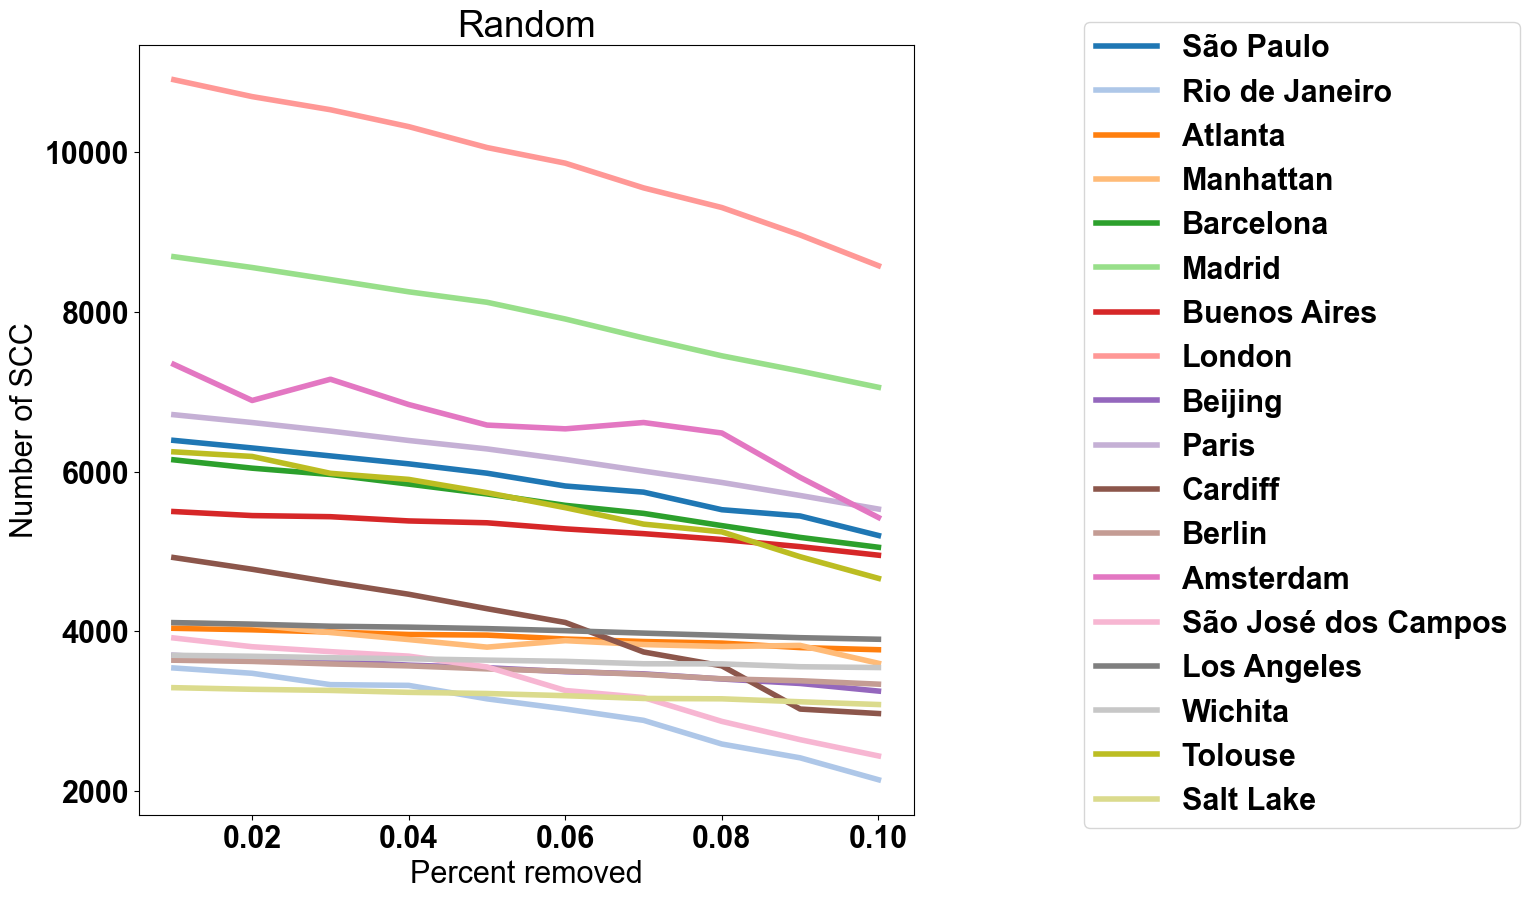

In [22]:
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
# for city in ["Amsterdam", "Wichita"]:
    plt.plot(percents, all_sccs_cities[f"{city} Mean"], label = city, c = c, linewidth = 4)
    c = next(colors)
# plt.ylim(top=2, bottom = 0)
plt.title("Random")
plt.xlabel("Percent removed")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.ylabel("Number of SCC")

### WCC

In [2]:
random.seed(10)

all_wccs_cities = pd.DataFrame(index = percents)
for city in city_list_full:
    randoms_wcc = pd.DataFrame(index = percents)
    G, nodes, edges = get_Graph(city)
    for k in range(10):
        total_wccs = []
        for j in percents:
            randoms_sample = random.sample(list(edges.index), k = int(j*len(edges)))
            H = nx.MultiGraph.copy(G)
            H.remove_edges_from(randoms_sample)
            wccs = []
            for i in nx.weakly_connected_components(H):
                wccs.append(len(i))
            total_wccs.append(max(wccs)/G.number_of_nodes())
        randoms_wcc[str(k)] = total_wccs
    all_wccs_cities[city] = randoms_wcc.T.mean()
    all_wccs_cities[f"{city} stdp"] = randoms_wcc.T.mean() + randoms_wcc.T.std()
    all_wccs_cities[f"{city} stdm"] = randoms_wcc.T.mean() - randoms_wcc.T.std()

In [6]:
randoms_wcc.T.std()/randoms_wcc.T.mean()*100

0.01    0.000000
0.02    0.019120
0.03    0.015613
0.04    0.045644
0.05    0.034917
0.06    0.046863
0.07    0.112344
0.08    0.063893
0.09    0.074795
0.10    0.097134
dtype: float64

Text(0, 0.5, 'Number of WCC')

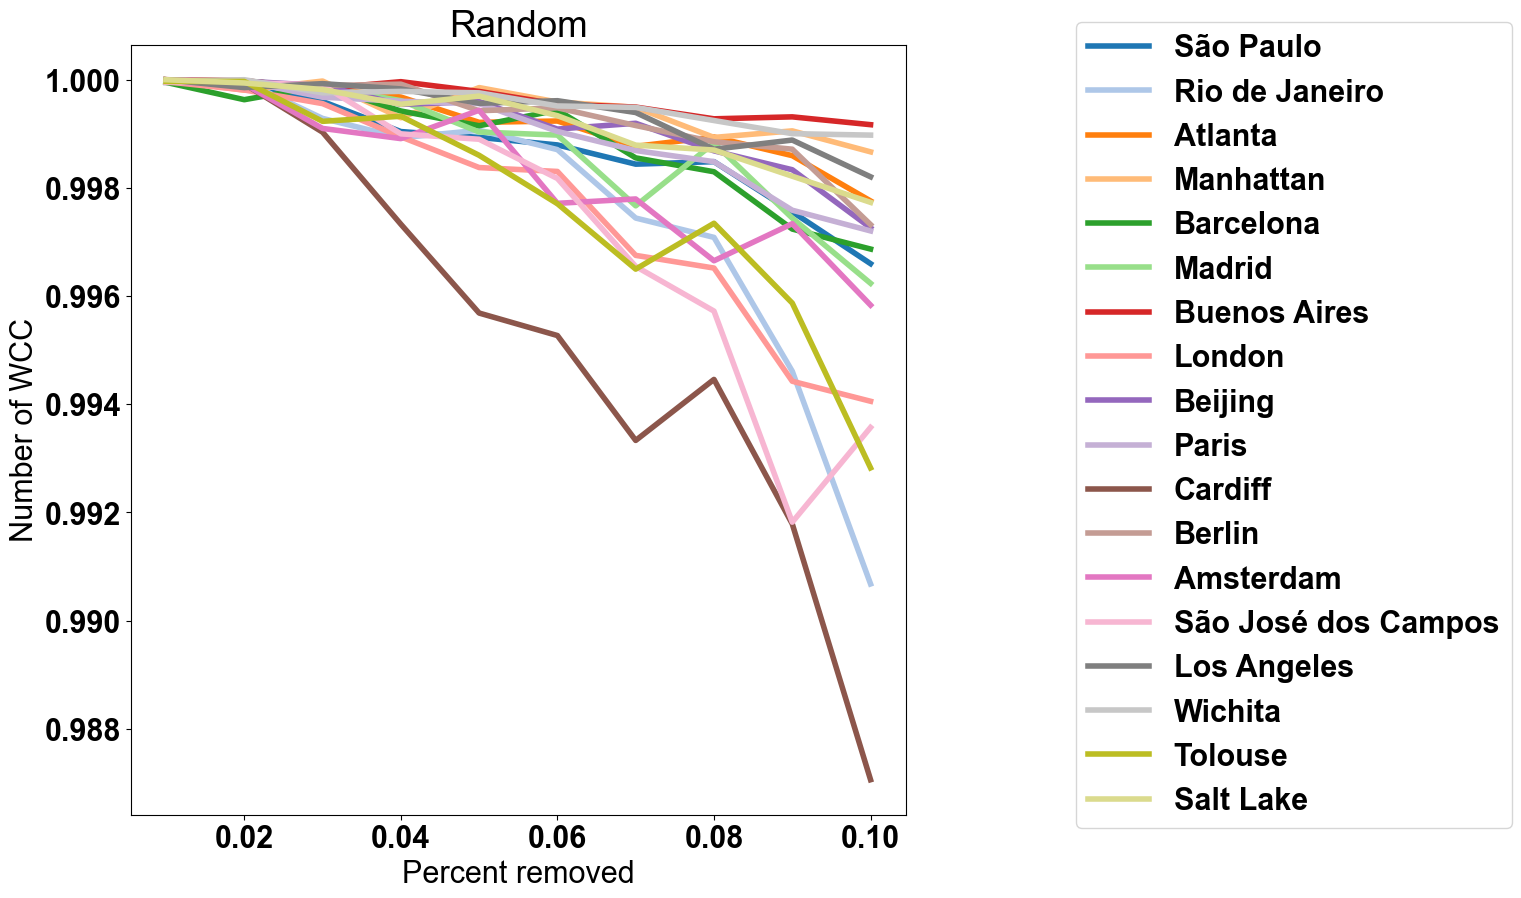

In [25]:
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
# for city in ["Amsterdam", "Wichita"]:
    plt.plot(percents, all_wccs_cities[f"{city}"], label = city, c = c, linewidth = 4)
    c = next(colors)
# plt.ylim(top=2, bottom = 0)
plt.title("Random")
plt.xlabel("Percent removed")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.ylabel("Number of WCC")

# COR

## SCC

### Low

In [26]:
all_sccs_low = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_sccs = []
    for j in percents:
        # topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(0.05*len(edges))).index
        lowcor = edges.sort_values(by = "Cost of returning", ascending = True).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(lowcor)
        sccs = []
        for i in nx.strongly_connected_components(H):
            sccs.append(len(i))
        total_sccs.append(len(sccs))
    all_sccs_low[city] = total_sccs

# plt.figure(figsize=(8,8))


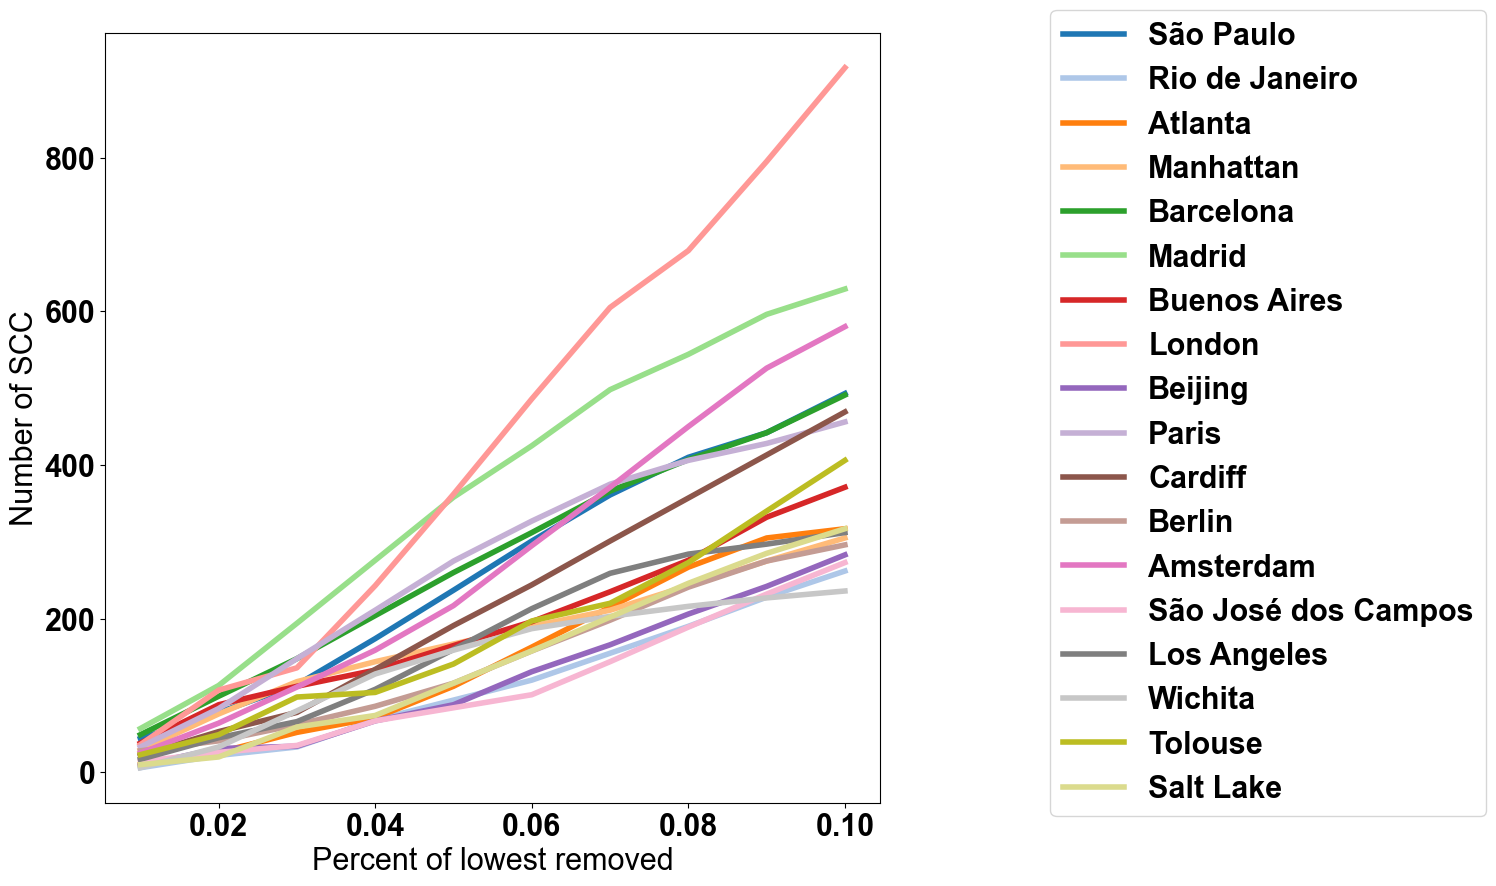

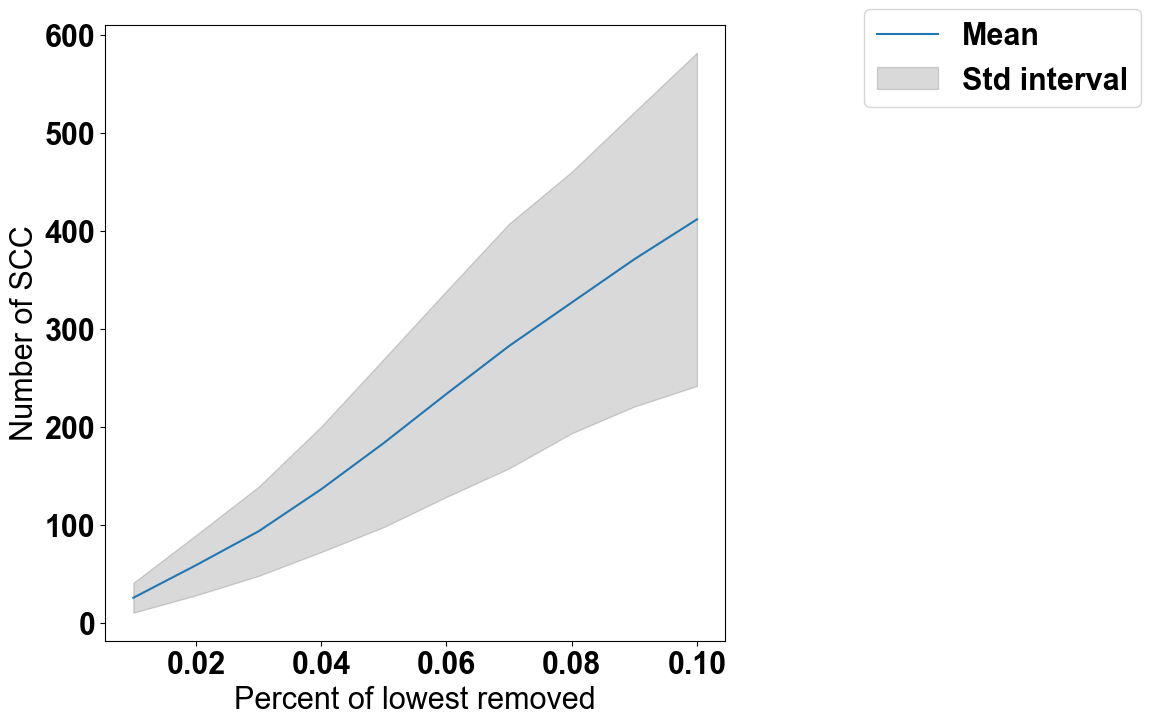

In [27]:
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_sccs_low[city], linewidth = 4, c = c, label = city)
    c = next(colors)

plt.xlabel("Percent of lowest removed")
plt.ylabel("Number of SCC")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

mean = all_sccs_low.T.mean()
upper = all_sccs_low.T.mean() + all_sccs_low.T.std()
lower = all_sccs_low.T.mean() - all_sccs_low.T.std()
plt.figure(figsize=(8,8))
plt.plot(percents, mean, label = "Mean")
plt.fill_between(percents, upper, lower, color="k", alpha=0.15, label = "Std interval")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent of lowest removed")
plt.ylabel("Number of SCC")
plt.show()

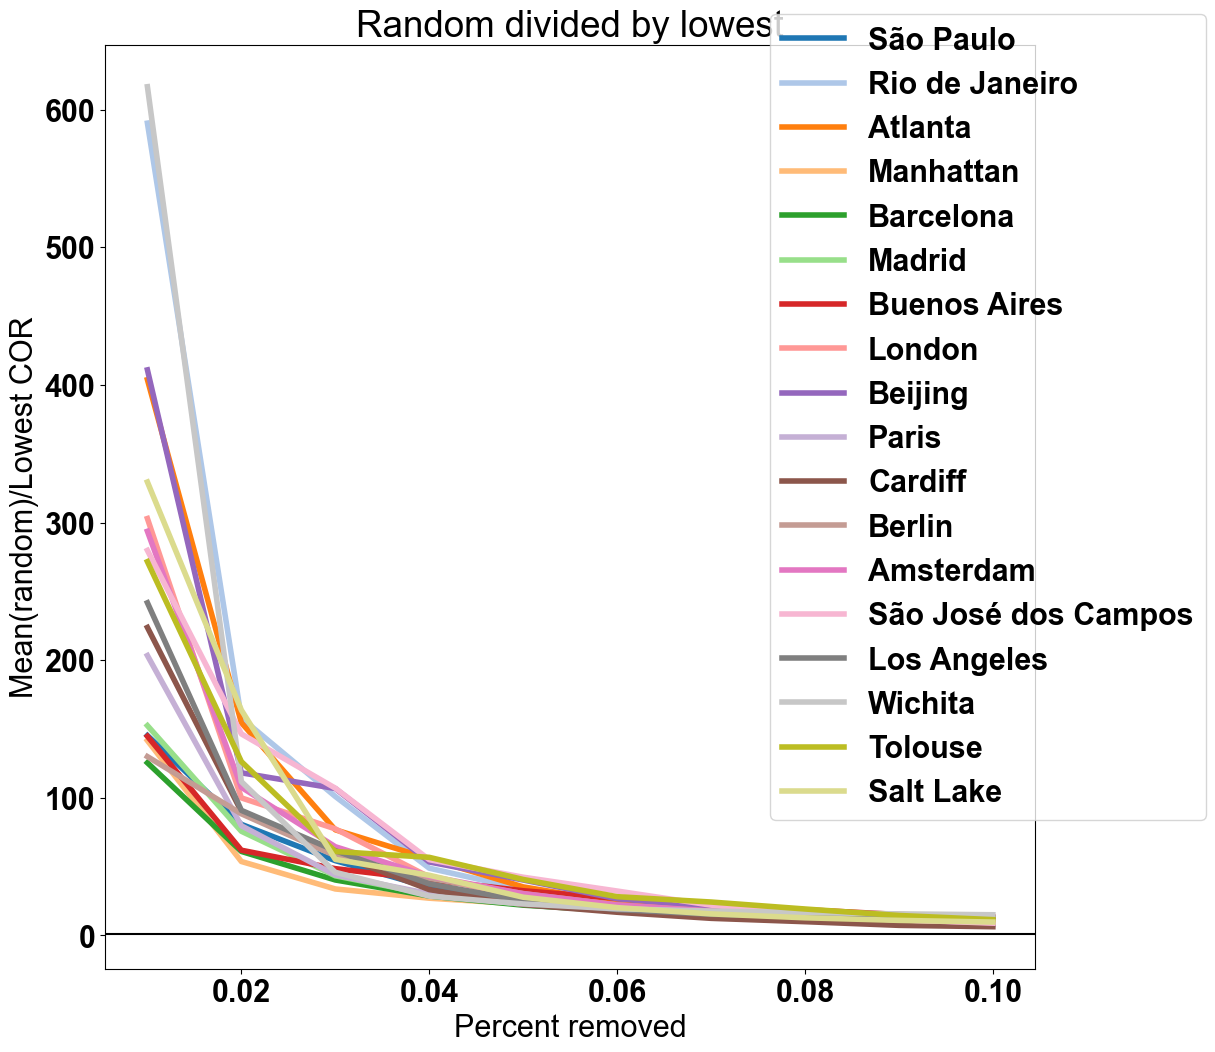

In [28]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_sccs_cities[f"{city} Mean"]/all_sccs_low[city], label = city, linewidth = 4, c = c)
    c = next(colors)

plt.title("Random divided by lowest")
plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Mean(random)/Lowest COR")
plt.show()

### High

In [29]:
all_sccs_high = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_sccs = []
    for j in percents:
        topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(topcor)
        sccs = []
        for i in nx.strongly_connected_components(H):
            sccs.append(len(i))
        total_sccs.append(max(sccs))
    all_sccs_high[city] = total_sccs



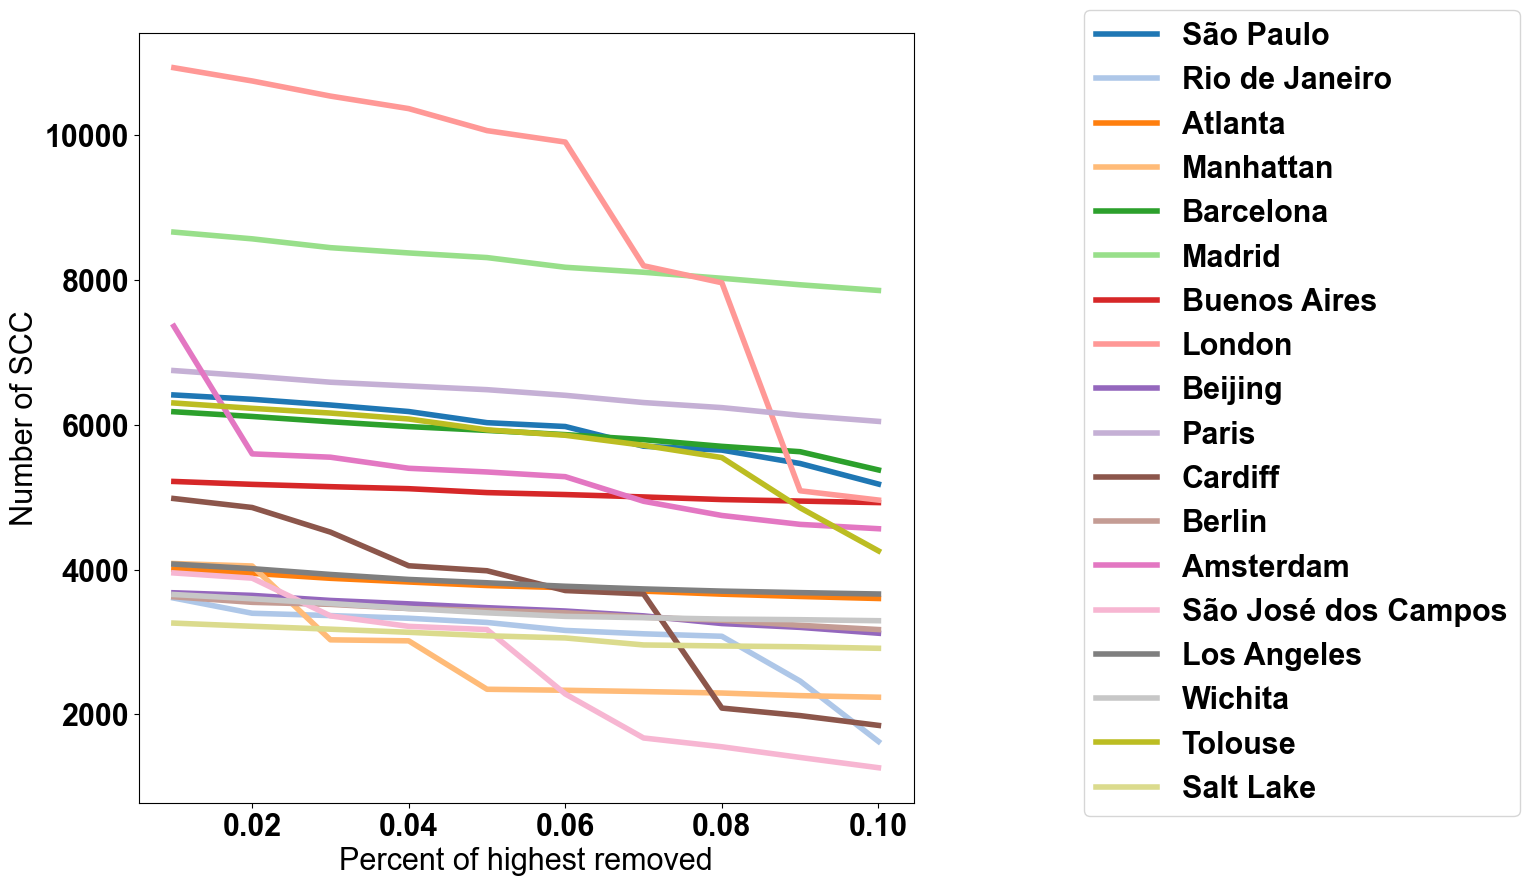

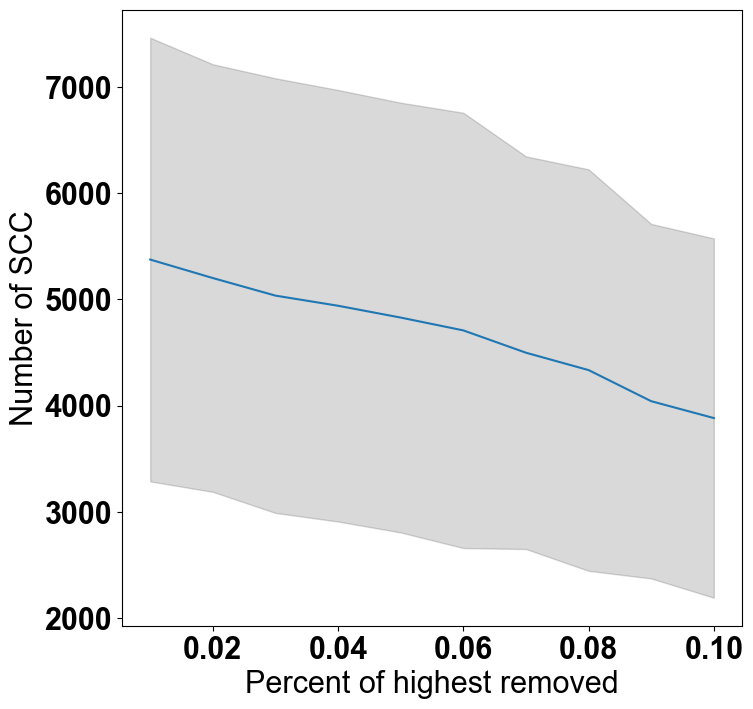

In [30]:
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_sccs_high[city], linewidth = 4, c = c, label = city)
    c = next(colors)

plt.xlabel("Percent of highest removed")
plt.ylabel("Number of SCC")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

mean = all_sccs_high.T.mean()
upper = all_sccs_high.T.mean() + all_sccs_high.T.std()
lower = all_sccs_high.T.mean() - all_sccs_high.T.std()
plt.figure(figsize=(8,8))
plt.plot(percents, mean, label = "Mean")
plt.fill_between(percents, upper, lower, color="k", alpha=0.15, label = "Std interval")
plt.xlabel("Percent of highest removed")
plt.ylabel("Number of SCC")
plt.show()

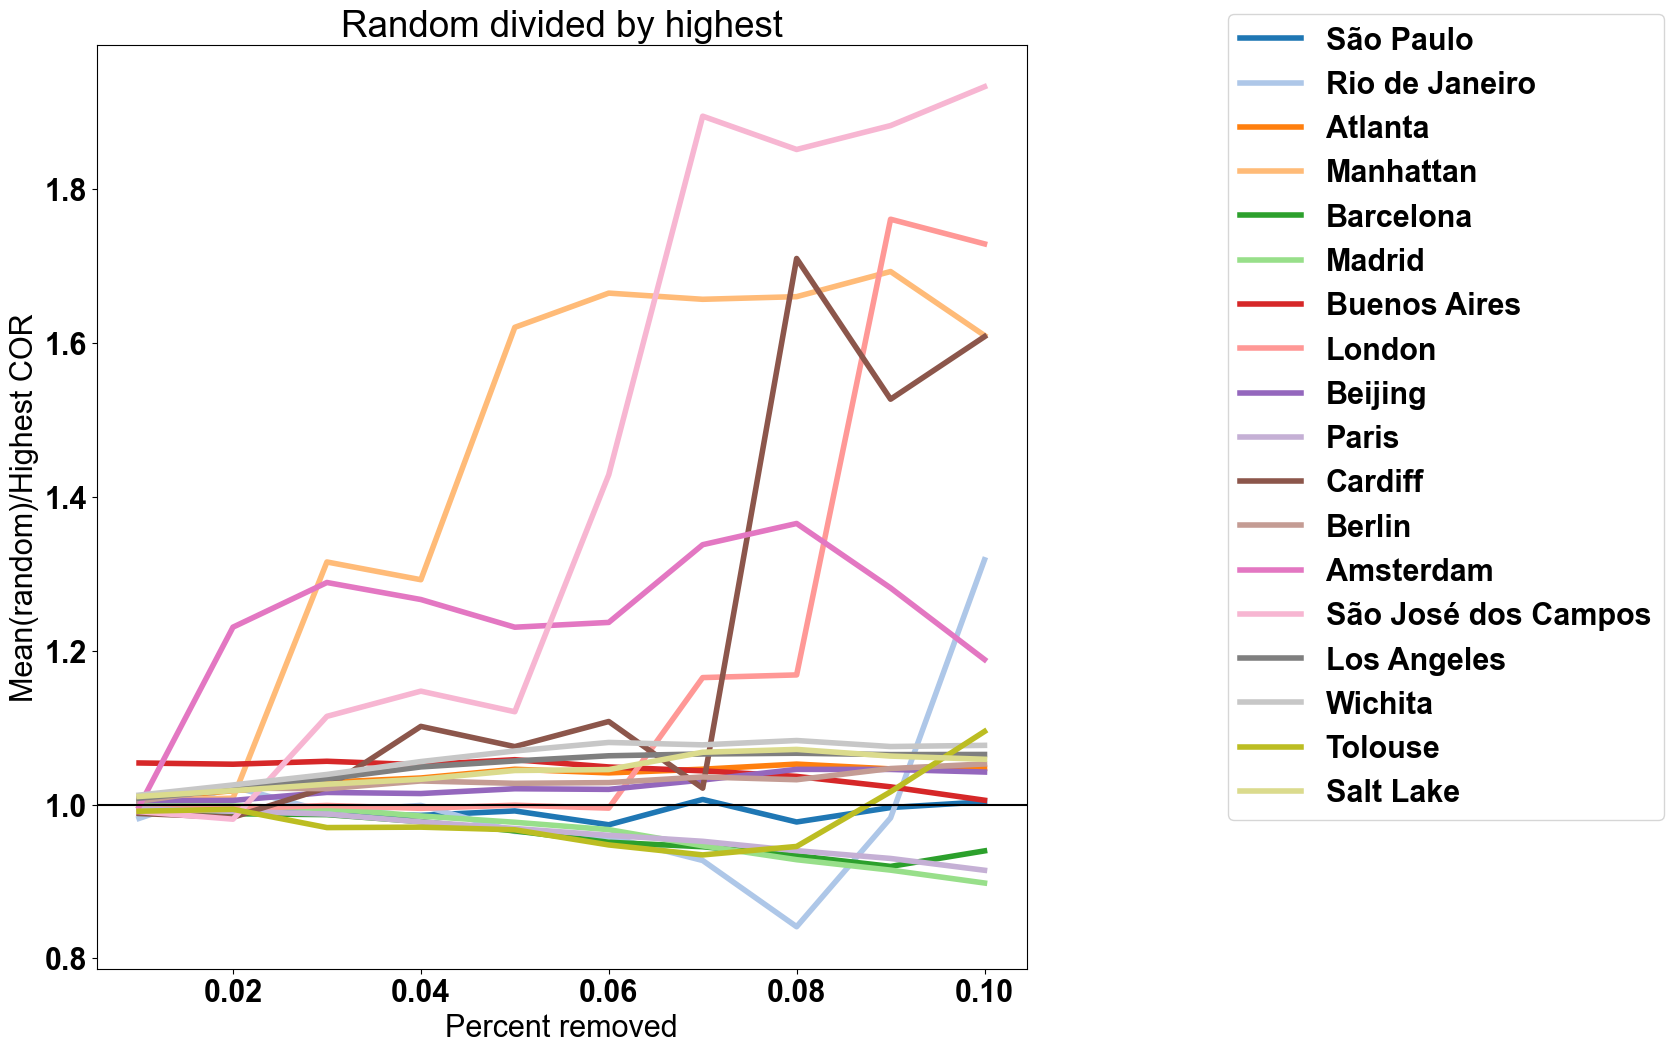

In [31]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_sccs_cities[f"{city} Mean"]/all_sccs_high[city], label = city, linewidth = 4, c = c)
    c = next(colors)
plt.axhline(1, c='k')
plt.title("Random divided by highest")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Mean(random)/Highest COR")
plt.show()

## WCC

### Low

In [32]:
all_wccs_low = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_wccs = []
    for j in percents:
        # topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(0.05*len(edges))).index
        lowcor = edges.sort_values(by = "Cost of returning", ascending = True).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(lowcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(len(wccs))
    all_wccs_low[city] = total_wccs



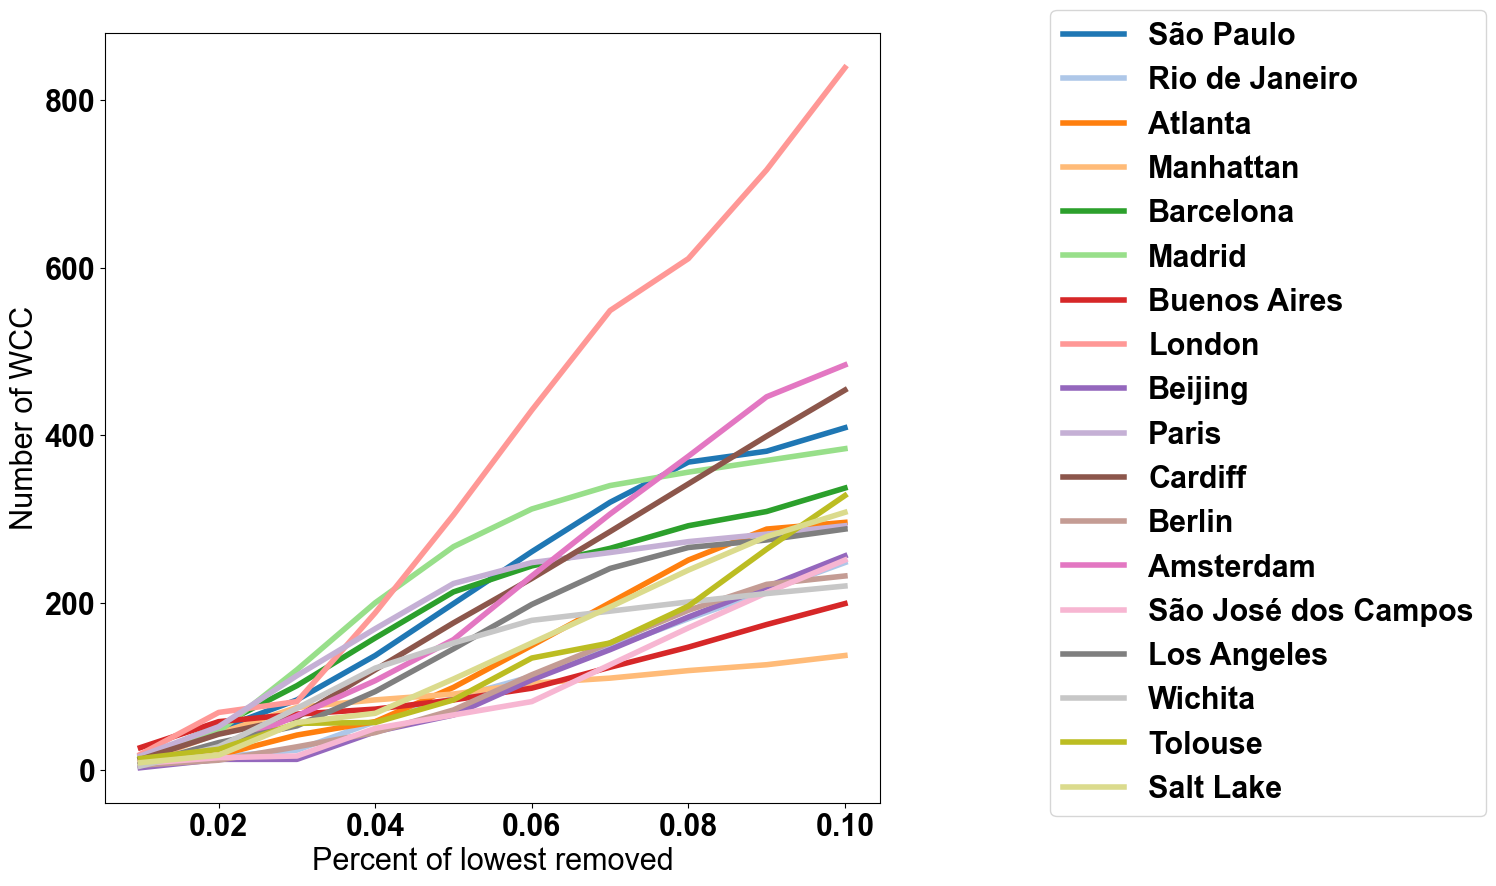

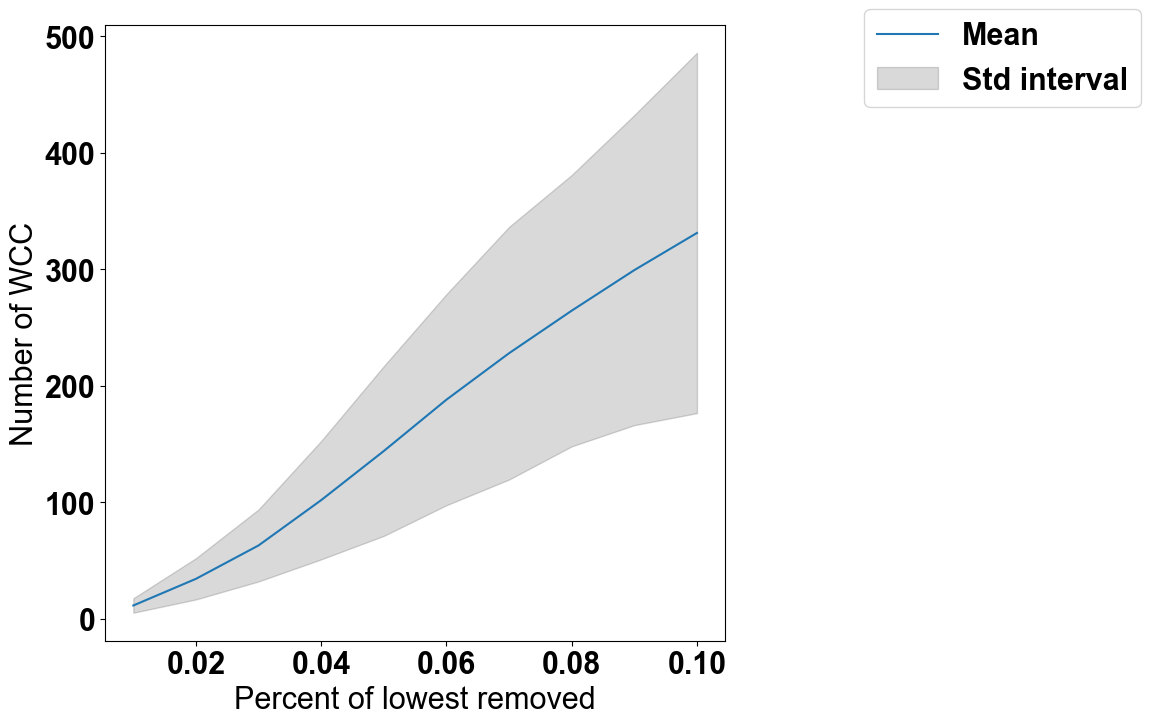

In [33]:
# plt.figure(figsize=(8,8))
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_low[city], linewidth = 4, c = c, label = city)
    c = next(colors)

plt.xlabel("Percent of lowest removed")
plt.ylabel("Number of WCC")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

mean = all_wccs_low.T.mean()
upper = all_wccs_low.T.mean() + all_wccs_low.T.std()
lower = all_wccs_low.T.mean() - all_wccs_low.T.std()
plt.figure(figsize=(8,8))
plt.plot(percents, mean, label = "Mean")
plt.fill_between(percents, upper, lower, color="k", alpha=0.15, label = "Std interval")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent of lowest removed")
plt.ylabel("Number of WCC")
plt.show()

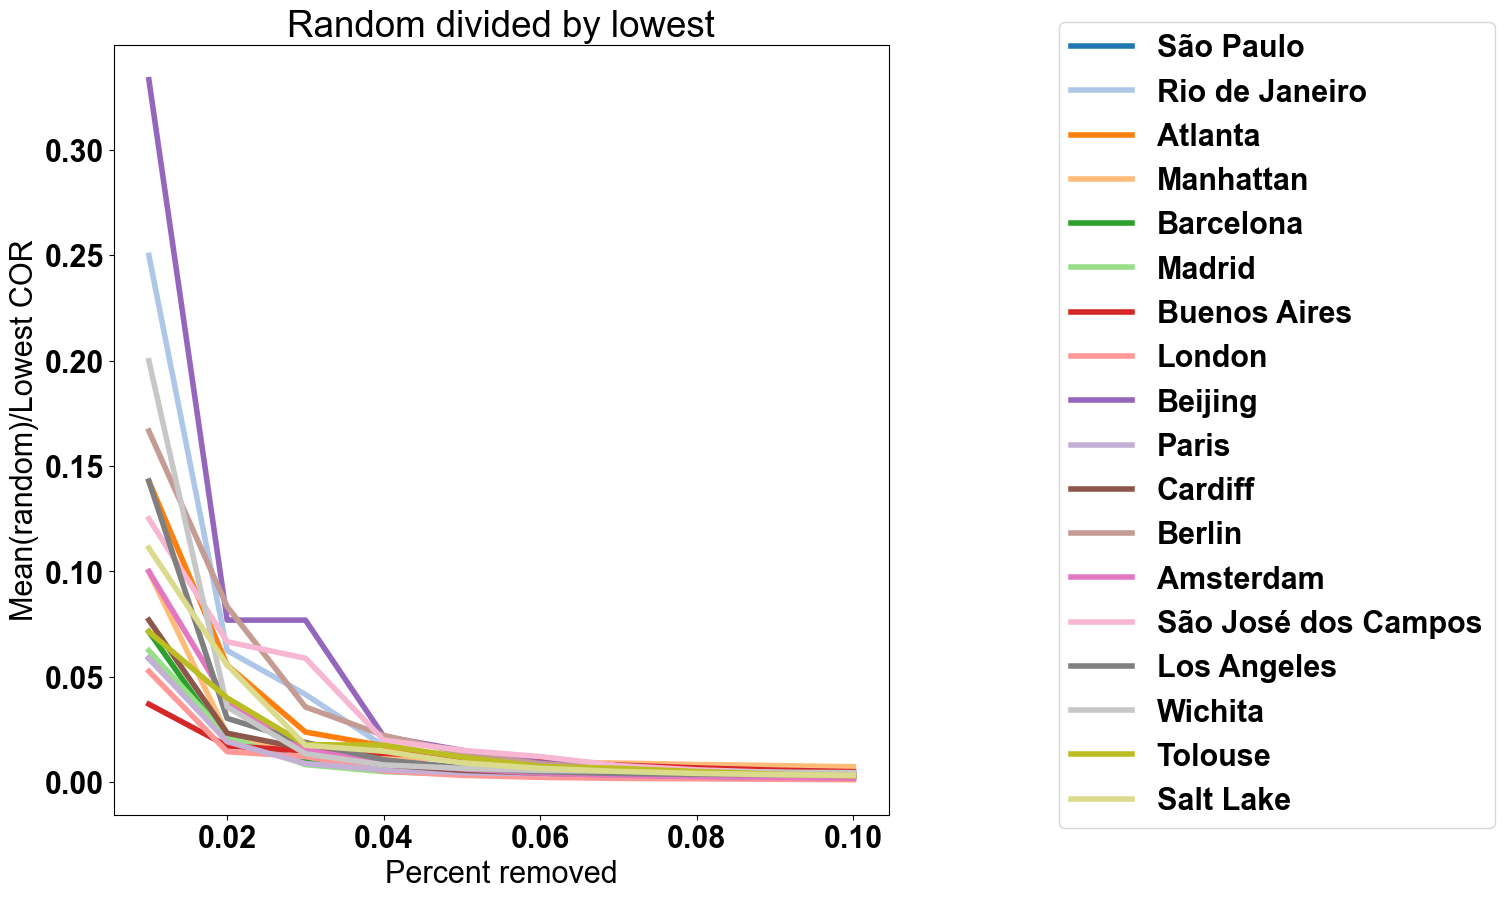

In [35]:
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_cities[f"{city}"]/all_wccs_low[city], label = city, linewidth = 4, c = c)
    c = next(colors)

plt.title("Random divided by lowest")
# plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Mean(random)/Lowest COR")
plt.show()

### High

In [36]:
all_wccs_high = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_wccs = []
    for j in percents:
        topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/G.number_of_nodes())
    all_wccs_high[city] = total_wccs



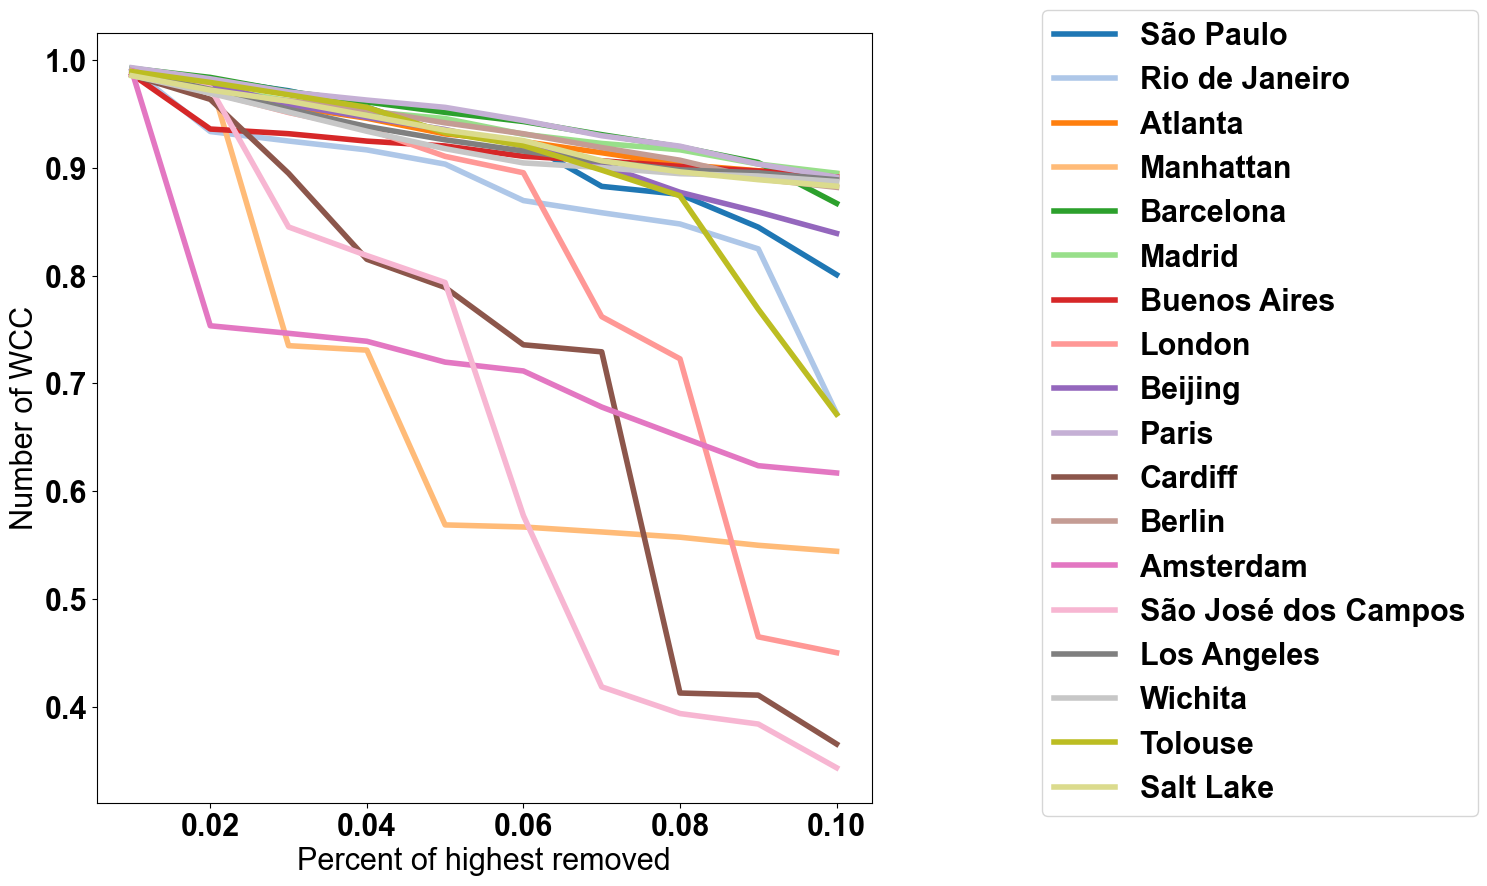

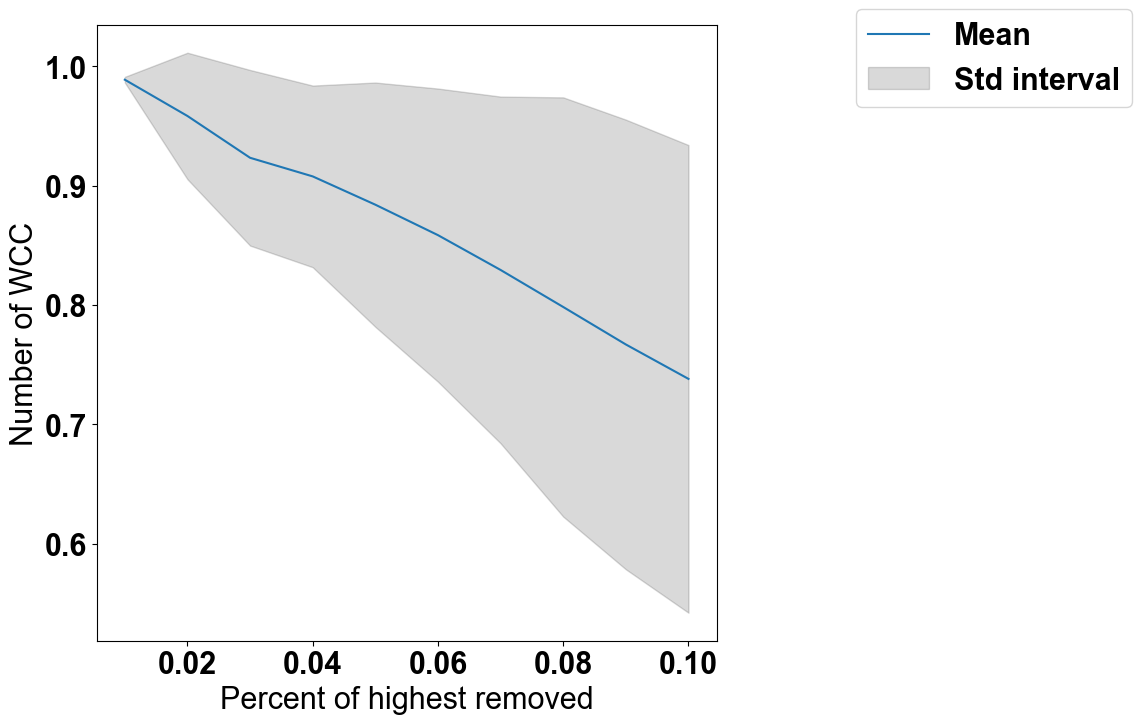

In [38]:
# plt.figure(figsize=(8,8))
plt.figure(figsize=(10,10))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_high[city], linewidth = 4, c = c, label = city)
    c = next(colors)

plt.xlabel("Percent of highest removed")
plt.ylabel("Number of WCC")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

mean = all_wccs_high.T.mean()
upper = all_wccs_high.T.mean() + all_wccs_high.T.std()
lower = all_wccs_high.T.mean() - all_wccs_high.T.std()
plt.figure(figsize=(8,8))
plt.plot(percents, mean, label = "Mean")
plt.fill_between(percents, upper, lower, color="k", alpha=0.15, label = "Std interval")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent of highest removed")
plt.ylabel("Number of WCC")
plt.show()

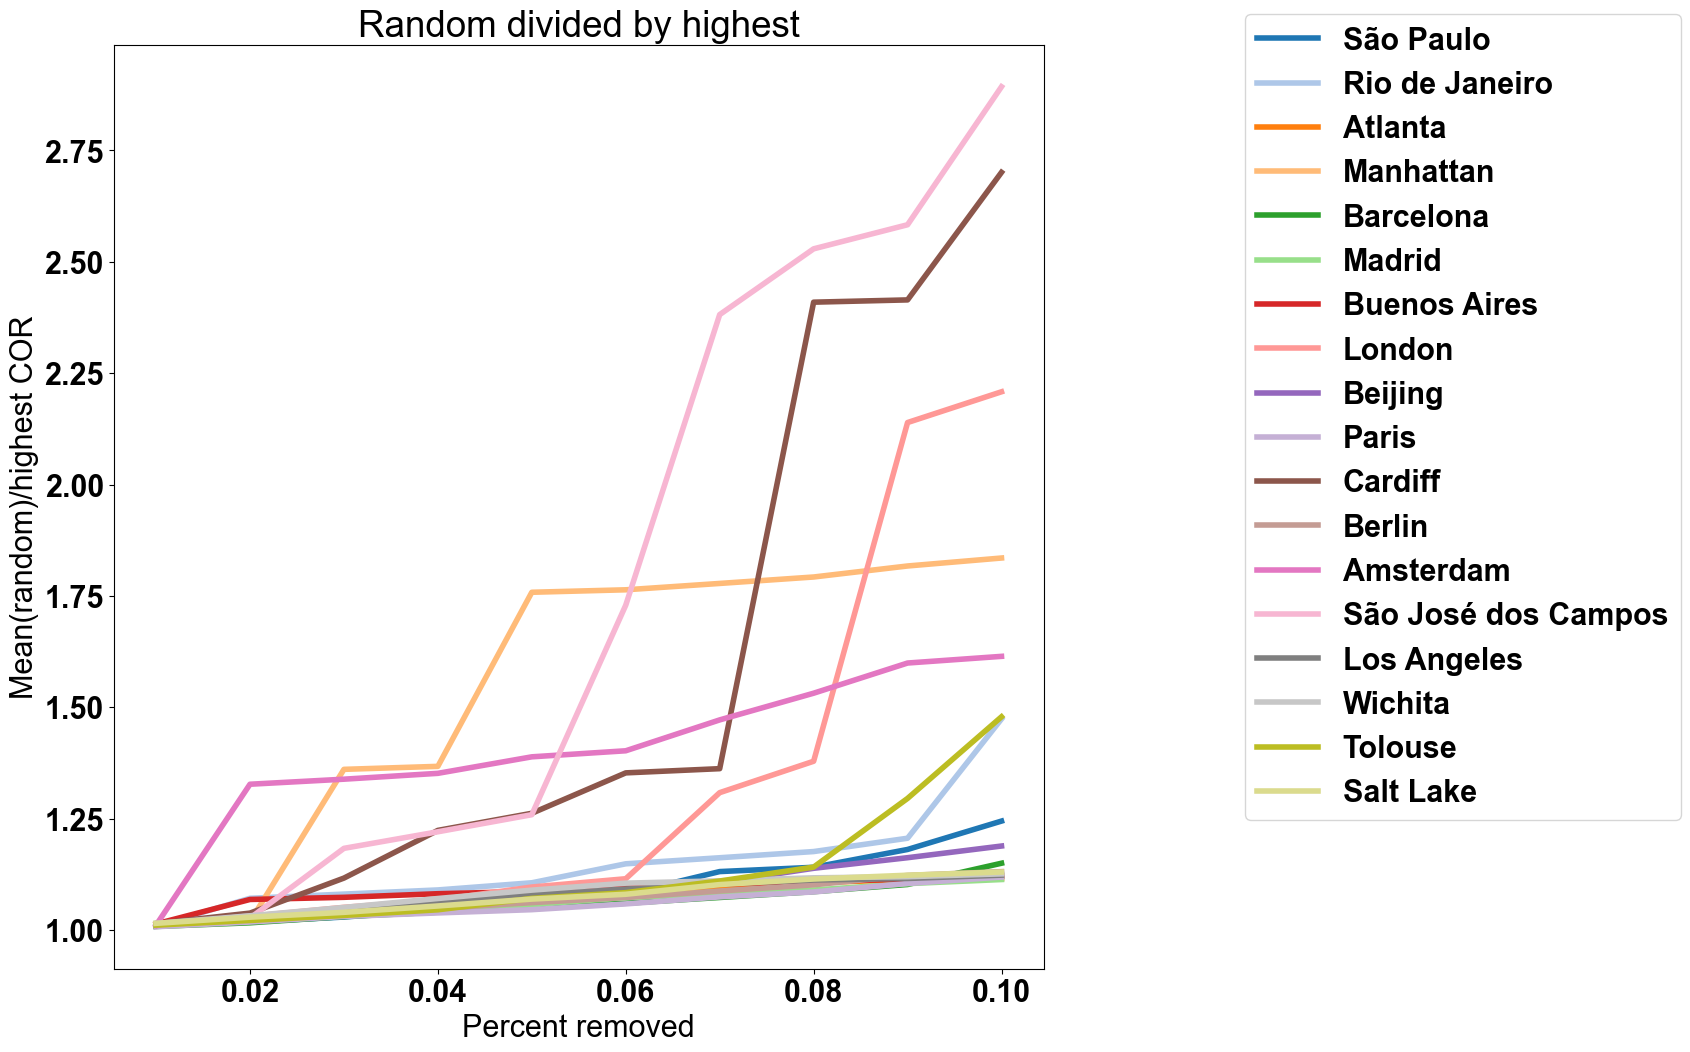

In [40]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_cities[f"{city}"]/all_wccs_high[city], label = city, linewidth = 4, c = c)
    c = next(colors)

plt.title("Random divided by highest")
# plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Mean(random)/highest COR")
plt.show()

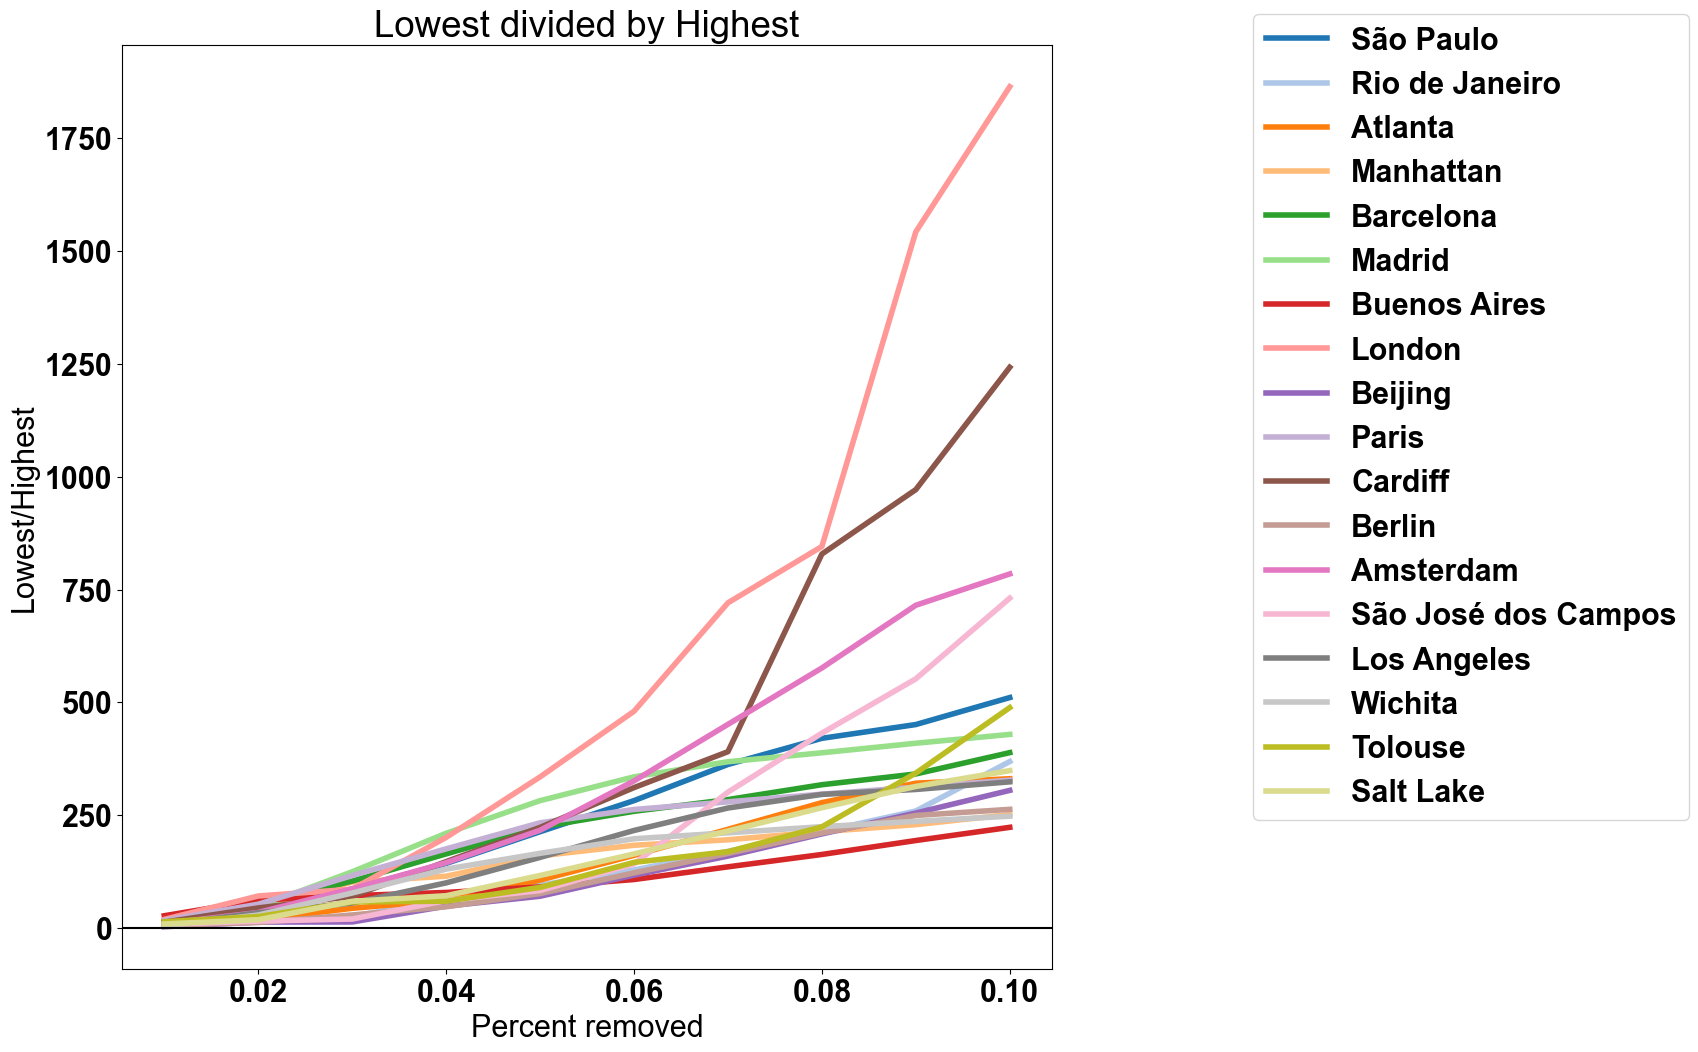

In [41]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_low[city]/all_wccs_high[city], label = city, linewidth = 4, c = c)
    c = next(colors)

plt.title("Lowest divided by Highest")
plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Lowest/Highest")
plt.show()

### High and low

In [44]:
all_wccs_both = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_wccs = []
    for j in percents:
        # topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(0.05*len(edges))).index
        lowcor = edges.sort_values(by = "Cost of returning", ascending = True).head(int(j*len(edges)/2)).index
        topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(j*len(edges)/2)).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(lowcor)
        H.remove_edges_from(topcor)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(len(wccs))
    all_wccs_both[city] = total_wccs



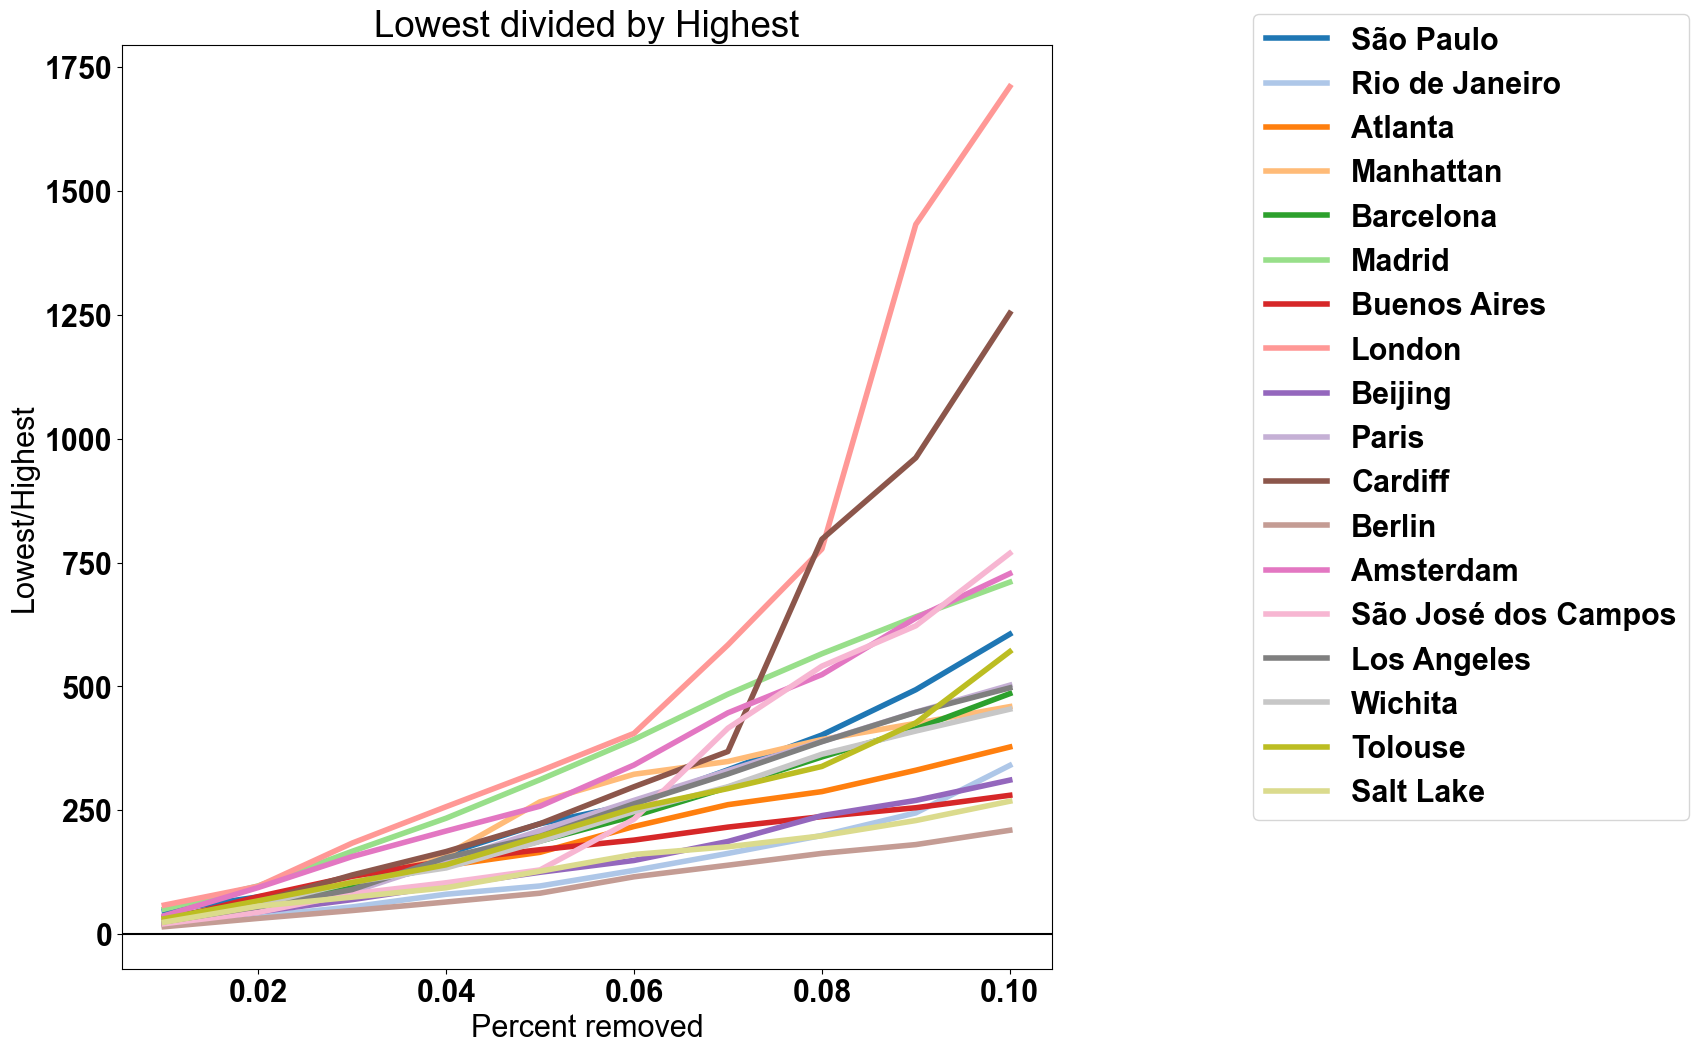

In [45]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_both[city]/all_wccs_high[city], label = city, linewidth = 4, c = c)
    c = next(colors)

plt.title("Lowest divided by Highest")
plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Lowest/Highest")
plt.show()

## Edge betweenness

### SCC

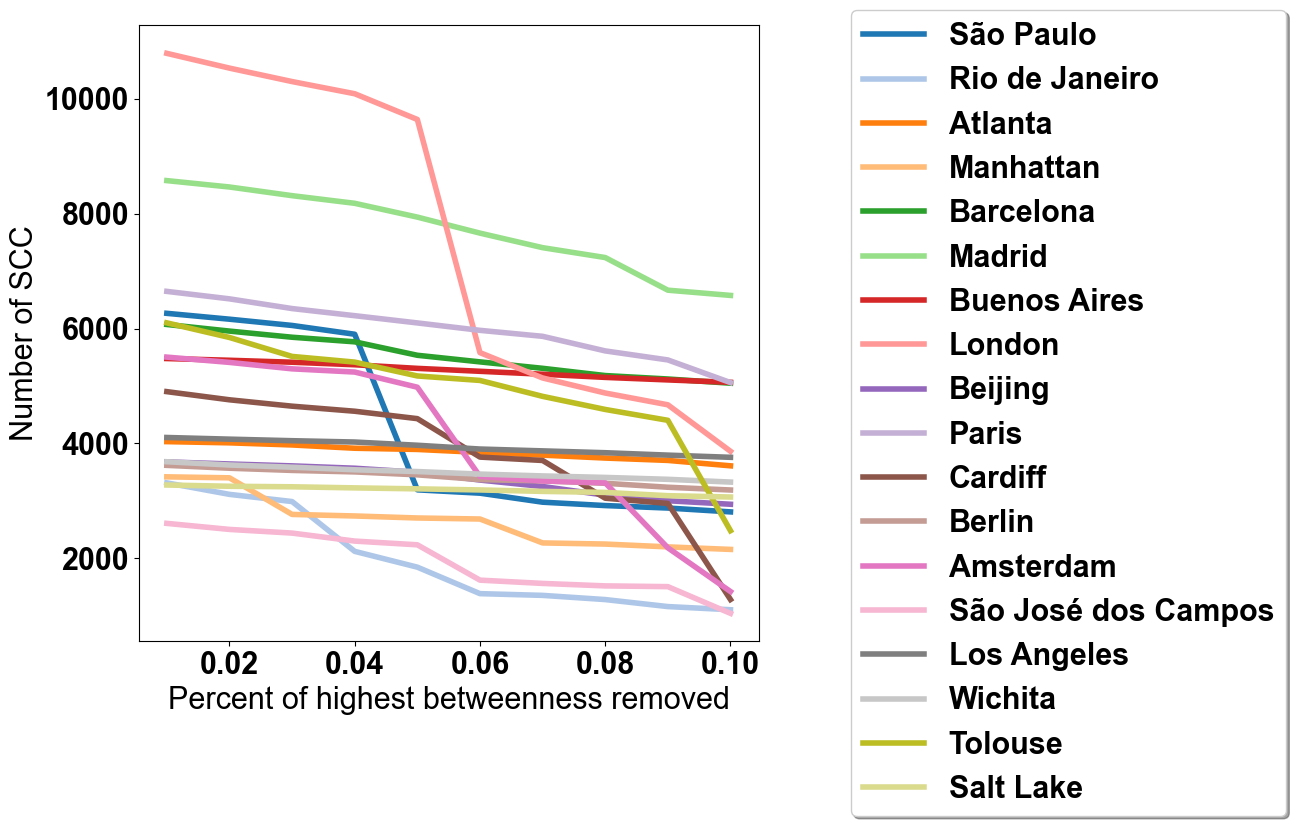

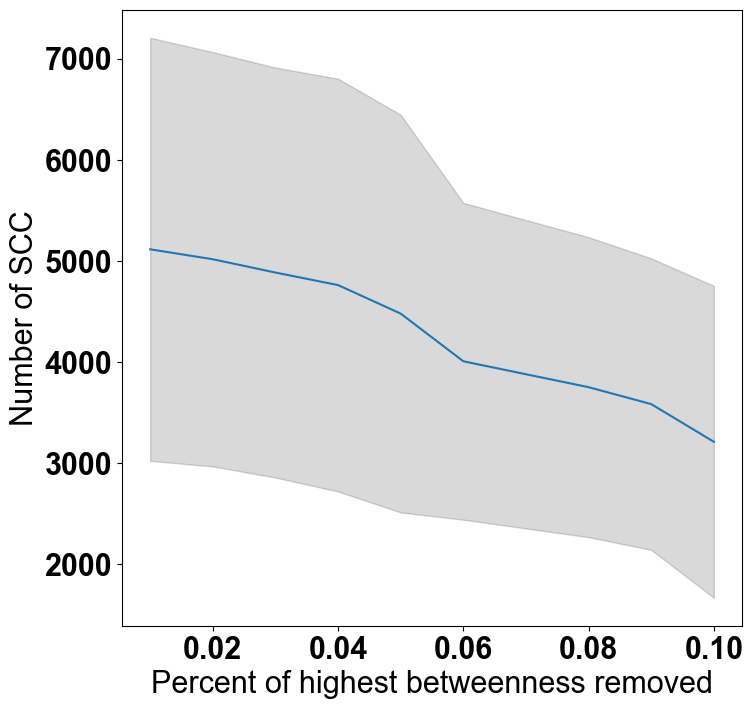

In [46]:
all_sccs_highb = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_sccs = []
    for j in percents:
        # topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(0.05*len(edges))).index
        highb = edges.sort_values(by = "Edge Betweenness", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(highb)
        sccs = []
        for i in nx.strongly_connected_components(H):
            sccs.append(len(i))
        total_sccs.append(max(sccs))
    all_sccs_highb[city] = total_sccs

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)

colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    ax.plot(percents, all_sccs_highb[city], c = c, label = city, linewidth = 4)
    c = next(colors)
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05),
          ncol=1, fancybox=True, shadow=True)
ax.set_xlabel("Percent of highest betweenness removed")
ax.set_ylabel("Number of SCC")
plt.show()

mean = all_sccs_highb.T.mean()
upper = all_sccs_highb.T.mean() + all_sccs_highb.T.std()
lower = all_sccs_highb.T.mean() - all_sccs_highb.T.std()
plt.figure(figsize=(8,8))
plt.plot(percents, mean, label = "Mean")
plt.fill_between(percents, upper, lower, color="k", alpha=0.15, label = "Std interval")
plt.xlabel("Percent of highest betweenness removed")
plt.ylabel("Number of SCC")
plt.show()

Text(0, 0.5, 'Highest betweenness/Highest COR')

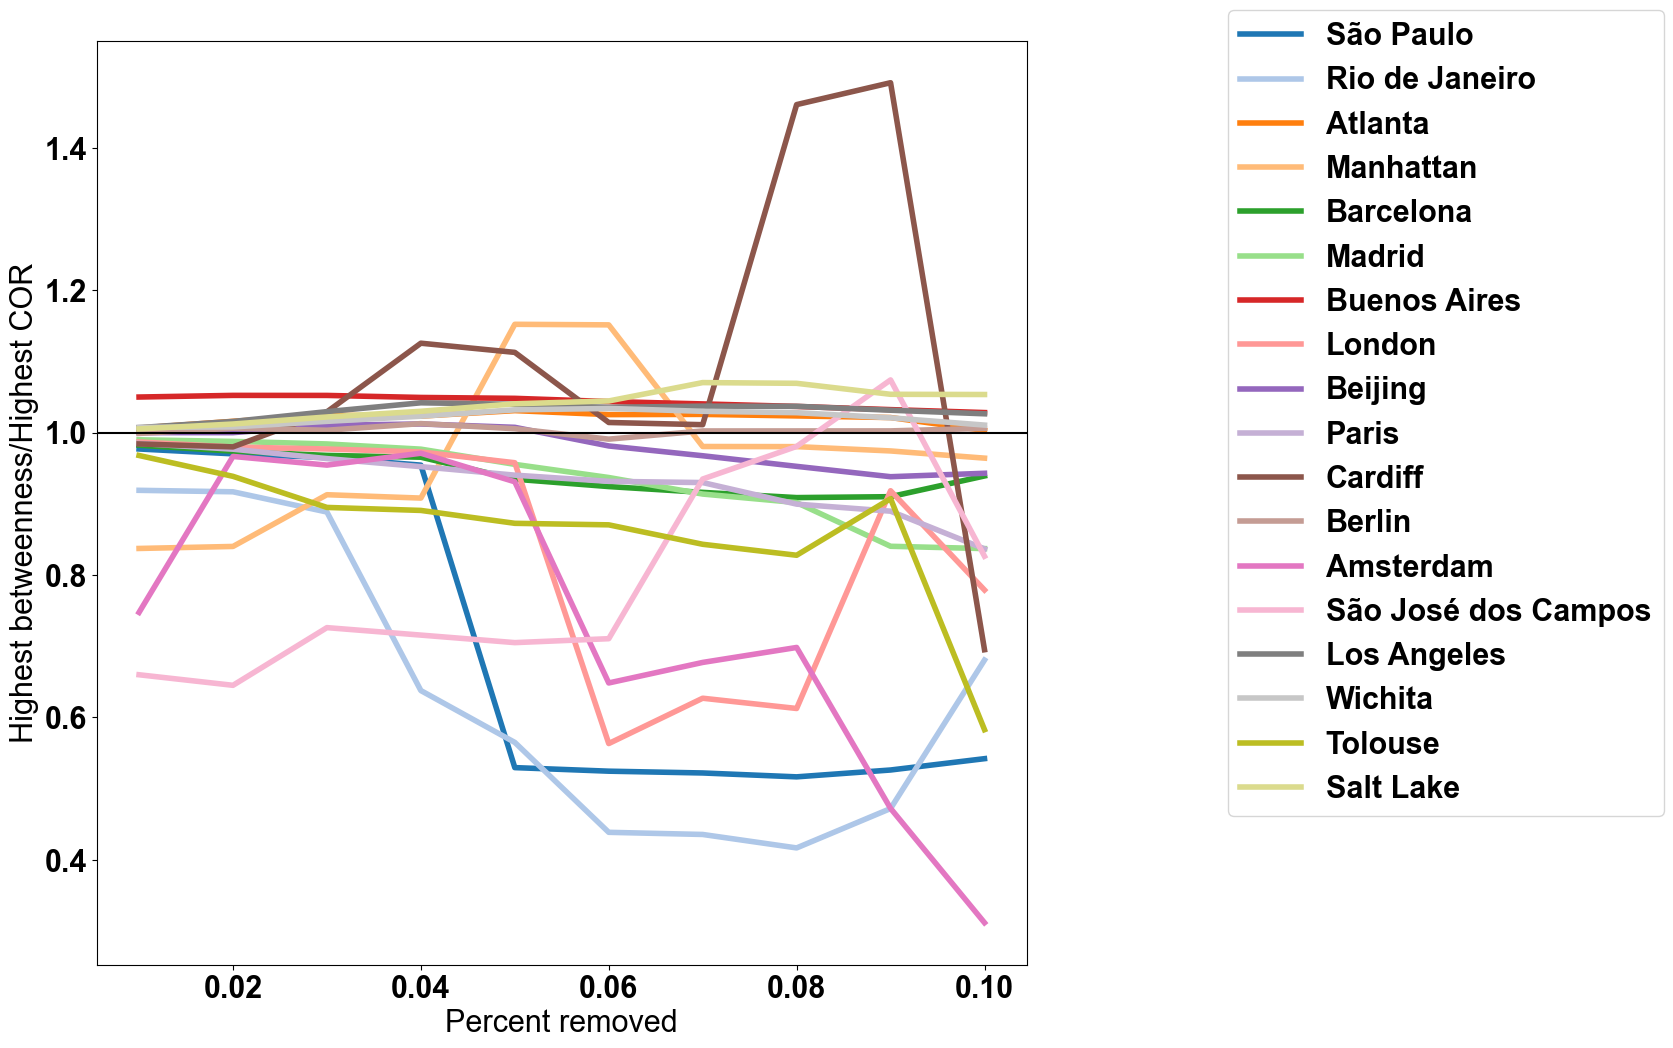

In [47]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_sccs_highb[f"{city}"]/all_sccs_high[city], label = city, linewidth = 4, c = c)
    c = next(colors)
plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Highest betweenness/Highest COR")

### WCC

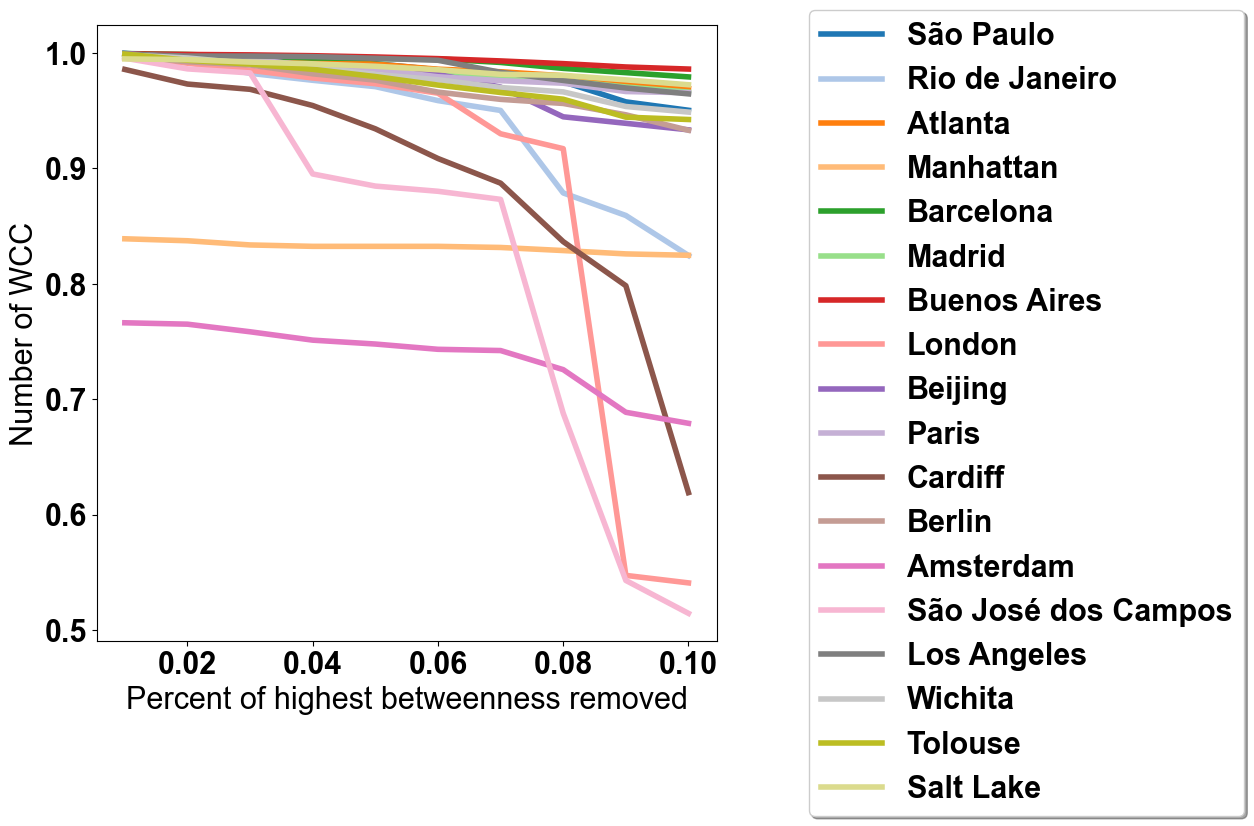

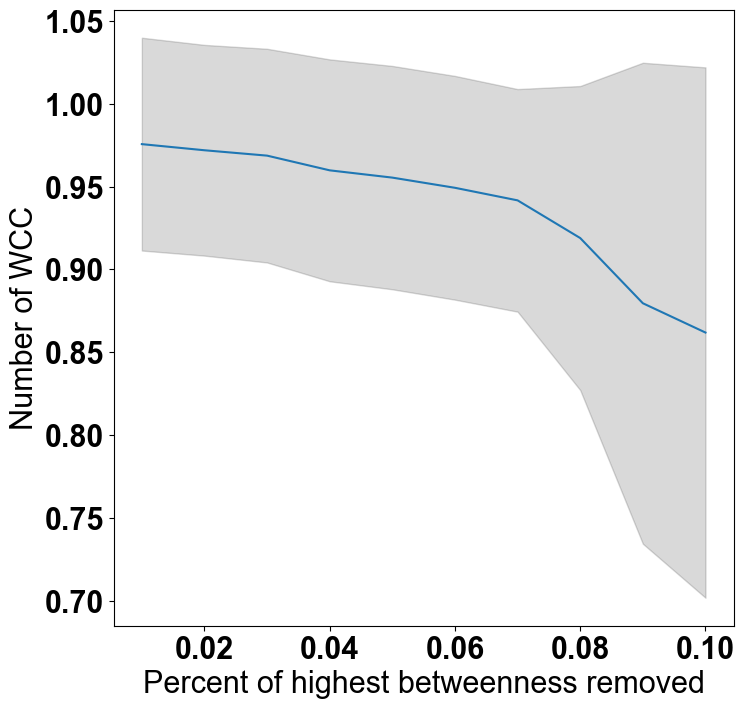

In [48]:
all_wccs_highb = pd.DataFrame(index = percents)
for city in city_list_full:
    G, nodes, edges = get_Graph(city)
    total_wccs = []
    for j in percents:
        highb = edges.sort_values(by = "Edge Betweenness", ascending = False).head(int(j*len(edges))).index
        H = nx.MultiGraph.copy(G)
        H.remove_edges_from(highb)
        wccs = []
        for i in nx.weakly_connected_components(H):
            wccs.append(len(i))
        total_wccs.append(max(wccs)/G.number_of_nodes())
        # print(H.number_of_edges()/G.number_of_edges())
        del(H)
    all_wccs_highb[city] = total_wccs

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)

colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    ax.plot(percents, all_wccs_highb[city], c = c, label = city, linewidth = 4)
    c = next(colors)
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05),
          ncol=1, fancybox=True, shadow=True)
ax.set_xlabel("Percent of highest betweenness removed")
ax.set_ylabel("Number of WCC")
plt.show()

mean = all_wccs_highb.T.mean()
upper = all_wccs_highb.T.mean() + all_wccs_highb.T.std()
lower = all_wccs_highb.T.mean() - all_wccs_highb.T.std()
plt.figure(figsize=(8,8))
plt.plot(percents, mean, label = "Mean")
plt.fill_between(percents, upper, lower, color="k", alpha=0.15, label = "Std interval")
plt.xlabel("Percent of highest betweenness removed")
plt.ylabel("Number of WCC")
plt.show()

In [49]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_cities[f'{city} Mean']/all_wccs_highb[f"{city}"], label = city, linewidth = 4, c = c)
    c = next(colors)
plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Mean(random)/Highest Betweenness")

KeyError: 'São Paulo Mean'

<Figure size 1200x1200 with 0 Axes>

Text(0, 0.5, 'Highest betweenness/Highest COR')

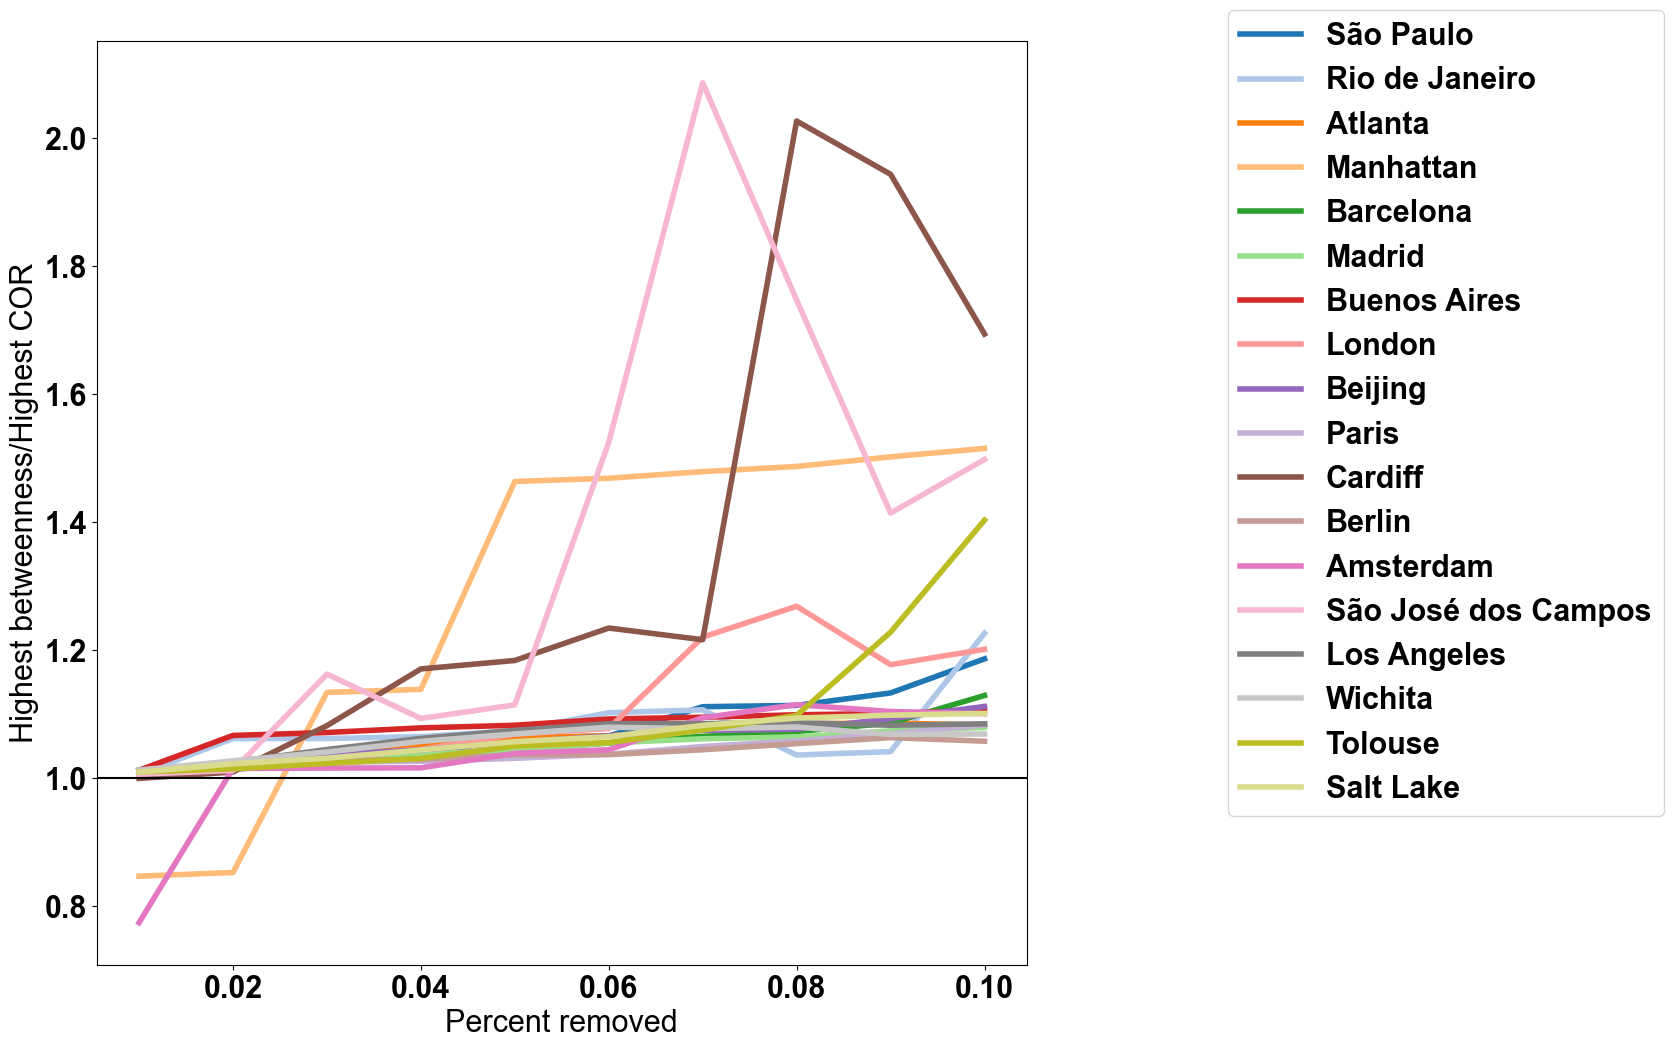

In [ ]:
plt.figure(figsize=(12,12))
colors = cycle(cm.tab20.colors)
c = next(colors)
for city in city_list_full:
    plt.plot(percents, all_wccs_highb[f"{city}"]/all_wccs_high[city], label = city, linewidth = 4, c = c)
    c = next(colors)
plt.axhline(1, c='k')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xlabel("Percent removed")
plt.ylabel("Highest betweenness/Highest COR")

In [ ]:
for i in city_list_full:
    all_wccs_cities.drop(columns=[f'{i} stdp', f'{i} stdm'], inplace=True)

In [ ]:
dfs = pd.DataFrame()
types = ["COR", "Betwenness", "Random"]
_elist = []
_type = []
_percent = []
kk = 0
for i in percents:
    # _elist = []
    for dframes in [all_wccs_high.T, all_wccs_highb.T, all_wccs_cities.T]:
        _elist = _elist + list(dframes[i])
        _percent += [i]*len(dframes)
        _type += [types[kk%3]]*len(dframes)
        kk+=1
dfs['Value'] = _elist
dfs["Percent"] = _percent
dfs["Type"] = _type

In [ ]:
fig = go.Figure()

for tipo in types:
    fig.add_trace(go.Box(x=dfs['Percent'][dfs['Type'] == tipo]*100,
                            y=dfs['Value'][dfs['Type'] == tipo],
                            name=tipo,
                            # box_visible=True,
                            # meanline_visible=True, spanmode='hard'
                            ))

fig.update_layout(
    # title="Plot Title",
    xaxis_title="Percent of edges removed",
    yaxis_title="Normalized WCC size",
    legend_title="Induced by",  
    font=dict(
        family="Computer Modern Roman",
        size=18,
        color="Black"
    ),
    xaxis = dict(
        tickmode = 'array',
        tickvals = percents*100,
    ),
    # violinmode='group',
    boxmode = 'group',
    # violingap=0.001,
    width = 1960/2,
    height = 1080/2,
    margin=dict(l=20, r=20, t=5, b=20),
)

fig.show()
fig.write_image("WCCs.pdf")

## # of paths

In [ ]:
# all_paths_highb = pd.DataFrame(index = percents)
# qtd = 100
# for city in city_list_full:
#     G, nodes, edges = get_Graph(city)
#     listpaths = []
#     for j in percents:
#         # topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(0.05*len(edges))).index
#         highb = edges.sort_values(by = "Edge Betweenness", ascending = False).head(int(j*len(edges))).index
#         H = nx.MultiGraph.copy(G)
#         H.remove_edges_from(highb)
#         OD_sample = random.sample(list(G.nodes()), k = 2*qtd)
#         Origin = OD_sample[:qtd]
#         Destiny = OD_sample[qtd:]
#         haspath = 0
#         for i in Origin:
#             for j in Destiny:
#                 haspath += (nx.has_path(H, i,j))
#         listpaths.append(haspath)
#     all_paths_highb[city] = listpaths

In [ ]:
# all_paths_high = pd.DataFrame(index = percents)
# for city in city_list_full:
#     G, nodes, edges = get_Graph(city)
#     listpaths = []
#     for j in percents:
#         # topcor = edges.sort_values(by = "Cost of returning", ascending = False).head(int(0.05*len(edges))).index
#         high = edges.sort_values(by = "Cost of returning", ascending = False).head(int(j*len(edges))).index
#         H = nx.MultiGraph.copy(G)
#         H.remove_edges_from(high)
#         OD_sample = random.sample(list(G.nodes()), k = 2*qtd)
#         Origin = OD_sample[:qtd]
#         Destiny = OD_sample[qtd:]
#         haspath = 0
#         for i in Origin:
#             for j in Destiny:
#                 haspath += (nx.has_path(H, i,j))
#         listpaths.append(haspath)
#     all_paths_high[city] = listpaths

In [ ]:
# plt.figure(figsize=(12,12))
# colors = cycle(cm.tab20.colors)
# c = next(colors)
# for city in city_list_full:
#     plt.plot(percents, all_paths_highb[city]/all_paths_high[city], label = city, linewidth = 4, c = c)
#     c = next(colors)
# plt.axhline(1, c='k')
# plt.legend(bbox_to_anchor=(1.2, 1.05))
# # plt.gca().invert_xaxis()
# plt.xlabel("Percentage removed edges")
# plt.ylabel("Highest COR WCC")

In [ ]:
# plt.figure(figsize=(12,12))
# colors = cycle(cm.tab20.colors)
# c = next(colors)
# for city in city_list_full:
#     plt.plot(all_paths_high[f"{city}"], all_wccs_high[city], label = city, linewidth = 4, c = c)
#     c = next(colors)
# plt.axhline(1, c='k')
# plt.legend(bbox_to_anchor=(1.2, 1.05))
# plt.gca().invert_xaxis()
# plt.xlabel("Percentage of possible OD")
# plt.ylabel("Highest COR WCC")